# EEG to ECG Reconstruction


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from lib.gpr_utils import  train_pulse
import os
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torchinfo import summary

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
load_from_file = True
prepro = False

# Parameters and setup
A = 2              # Amplitude of the train pulses
width = 0.05 / 3      # Width of each pulse
tau = 1            # Lag (downsampling factor)
duration_sec = 10  # segment length to plot

# Available subjects (info only)
subj_all = [29, 40, 23, 27, 28, 30, 39, 41]

# Pulse type for ECG transformation
impulso = "Gaussian"   # or rectangular

# Caching paths
cache_dir = "cache"
parsed_path = os.path.join(cache_dir, "data_parsed_noSubsample.pkl")
preproc_path = os.path.join(cache_dir, "data_preprocessed_noSubsample.pkl")

## Build training data
Loads preprocessed EEG, creates ECG pulse trains from R-peaks, normalizes, downsamples, and concatenates across training subjects.

In [8]:
def visualize_ecg_and_peaks(ss, ECG, ECG_pulse, EEG, R_peaks, time, freq, duration_sec=10):
    print(f"ECG -> Sampling frequency: {freq} Hz, Signal duration: {len(ECG)/freq} seconds, Channels: 1, no. of points: {len(ECG)}, no. of R peaks: {len(R_peaks)}")
    print(f"EEG -> Sampling frequency: {freq} Hz, Signal duration: {EEG.shape[1]/freq} seconds, Channels: {EEG.shape[0]}, no. of points: {EEG.shape[1]}")

    # Random start index
    start_idx = np.random.randint(0, len(time) - int(duration_sec * freq))
    end_idx = start_idx + int(duration_sec * freq)

    # Select R peaks in the segment and shift to relative indices
    R_seg = R_peaks[(R_peaks >= start_idx) & (R_peaks < end_idx)]

    plt.figure(figsize=(24, 4))
    plt.plot(time[start_idx:end_idx], ECG[start_idx:end_idx], label='ECG')
    plt.plot(time[start_idx:end_idx], ECG_pulse[start_idx:end_idx], label='Pulses')
    plt.scatter(time[R_seg], ECG[R_seg], s=20, edgecolors='red', facecolors='red', label='R_peaks')

    # Add dashed vertical lines at R peaks
    for rp in R_seg:
        plt.axvline(time[rp], color='k', linestyle='--', alpha=0.8, linewidth=1) # type: ignore

    plt.title(f'ECG and Pulses, Random 10s Segment, Subject {ss}')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.tight_layout()
    plt.show()


Loading training data for subject 29...
ECG -> Sampling frequency: 500.0 Hz, Signal duration: 466.57 seconds, Channels: 1, no. of points: 233285, no. of R peaks: 546
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 466.568 seconds, Channels: 128, no. of points: 233284


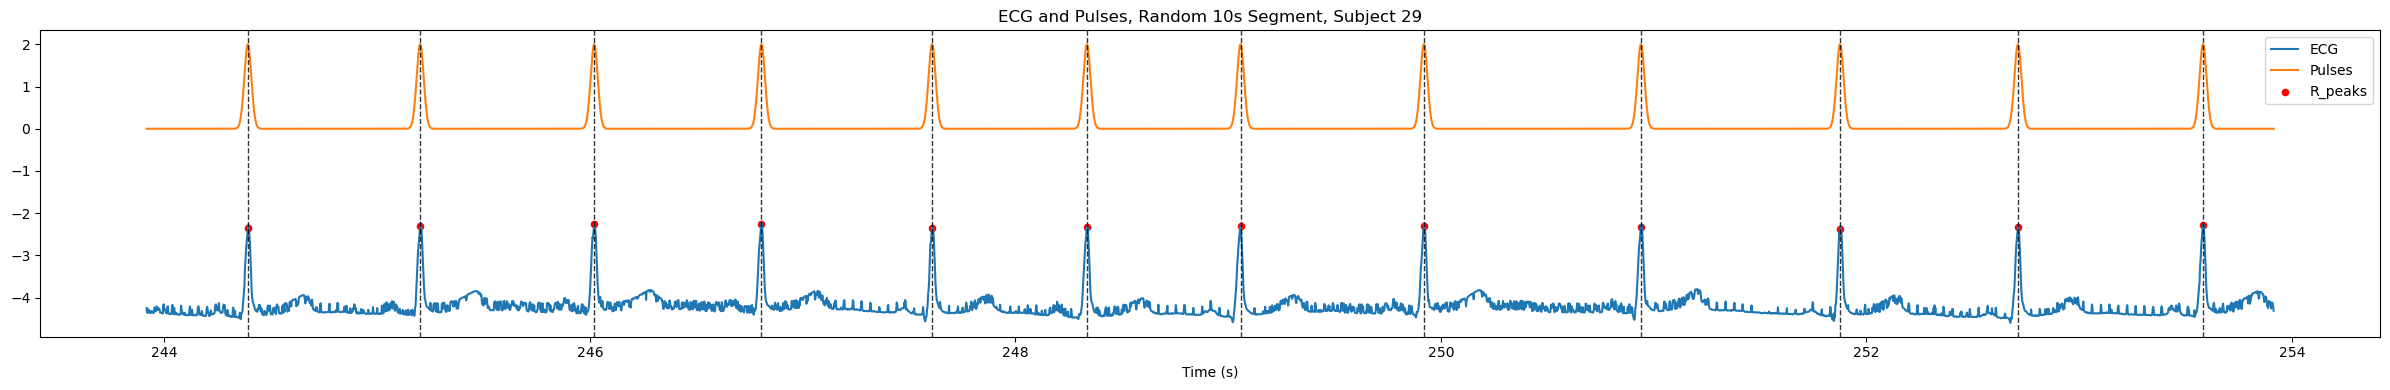


Loading training data for subject 40...
ECG -> Sampling frequency: 500.0 Hz, Signal duration: 462.22 seconds, Channels: 1, no. of points: 231110, no. of R peaks: 711
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 462.218 seconds, Channels: 128, no. of points: 231109


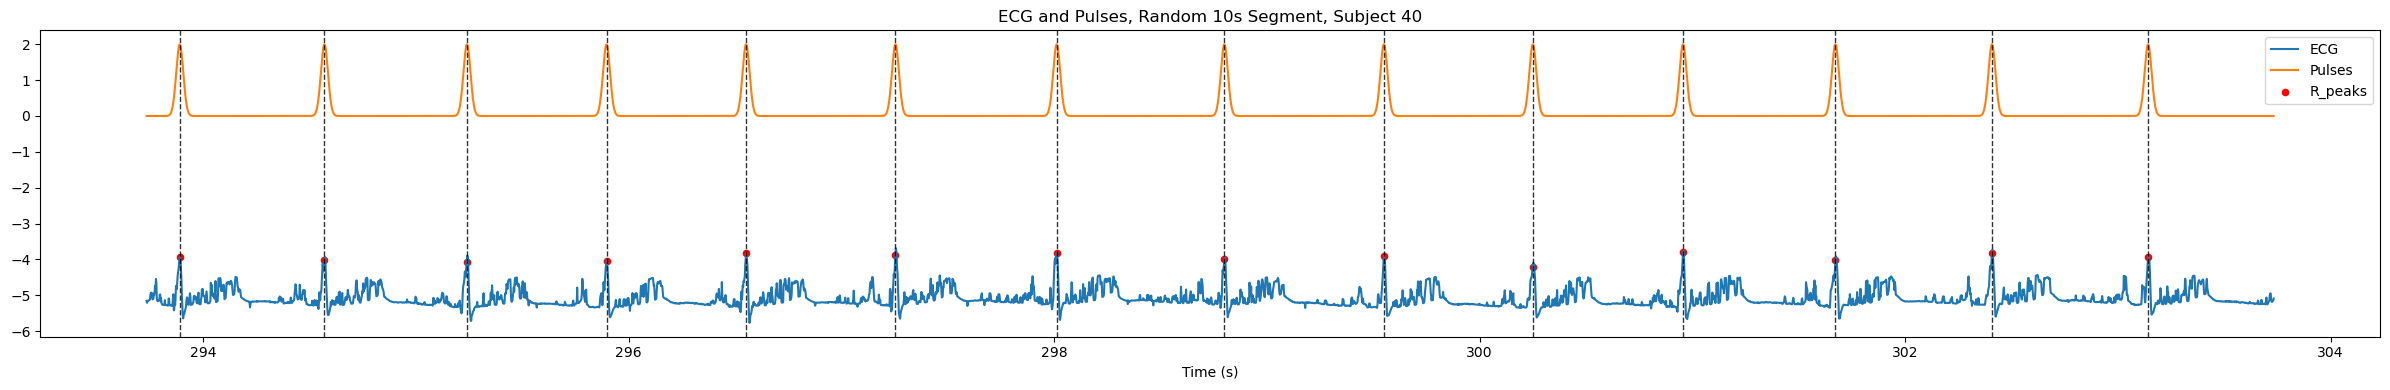


Loading training data for subject 23...
ECG -> Sampling frequency: 500.0 Hz, Signal duration: 509.77 seconds, Channels: 1, no. of points: 254885, no. of R peaks: 537
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 509.768 seconds, Channels: 128, no. of points: 254884


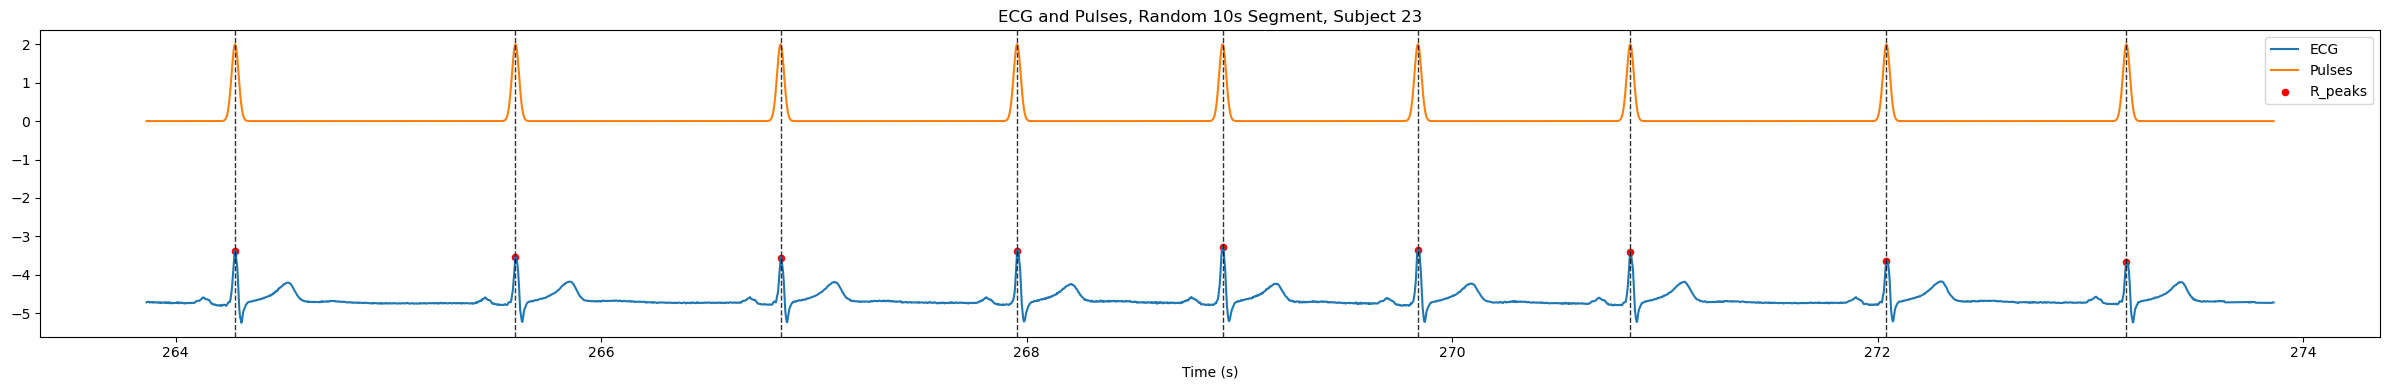


Loading training data for subject 27...
ECG -> Sampling frequency: 500.0 Hz, Signal duration: 446.216 seconds, Channels: 1, no. of points: 223108, no. of R peaks: 549
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 446.214 seconds, Channels: 128, no. of points: 223107


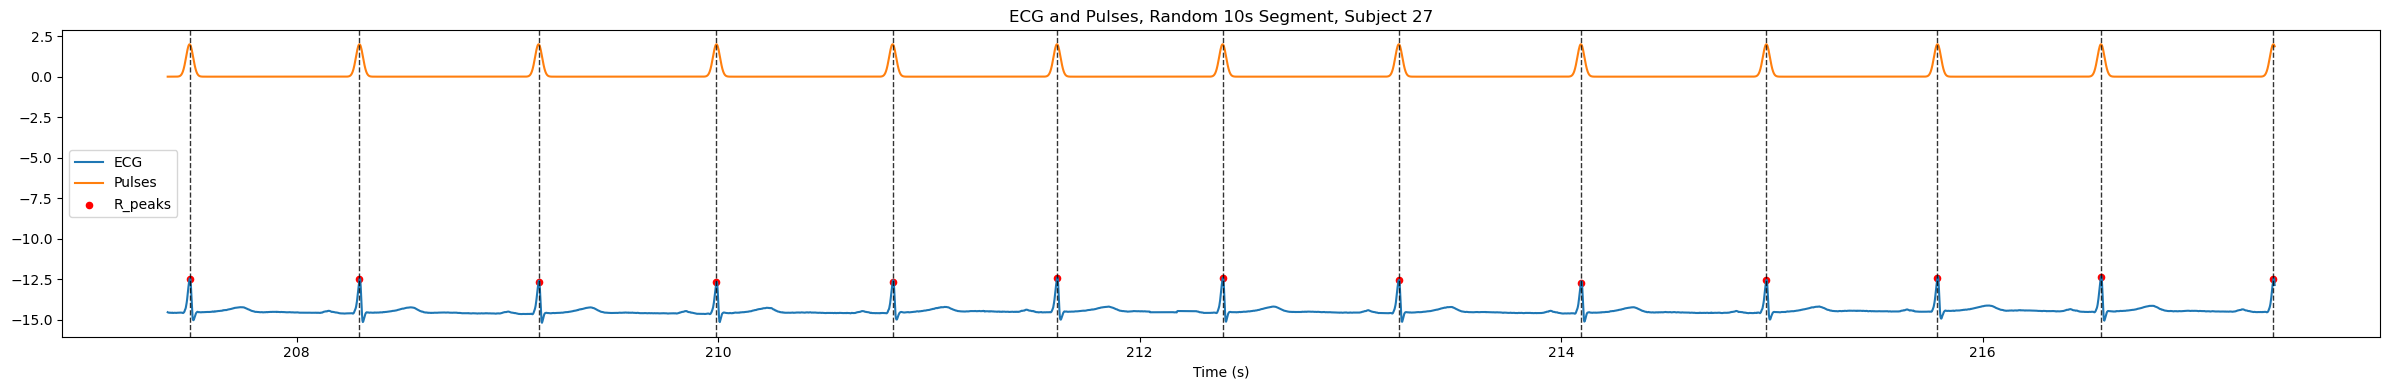


Loading training data for subject 28...
ECG -> Sampling frequency: 500.0 Hz, Signal duration: 422.668 seconds, Channels: 1, no. of points: 211334, no. of R peaks: 505
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 422.666 seconds, Channels: 128, no. of points: 211333


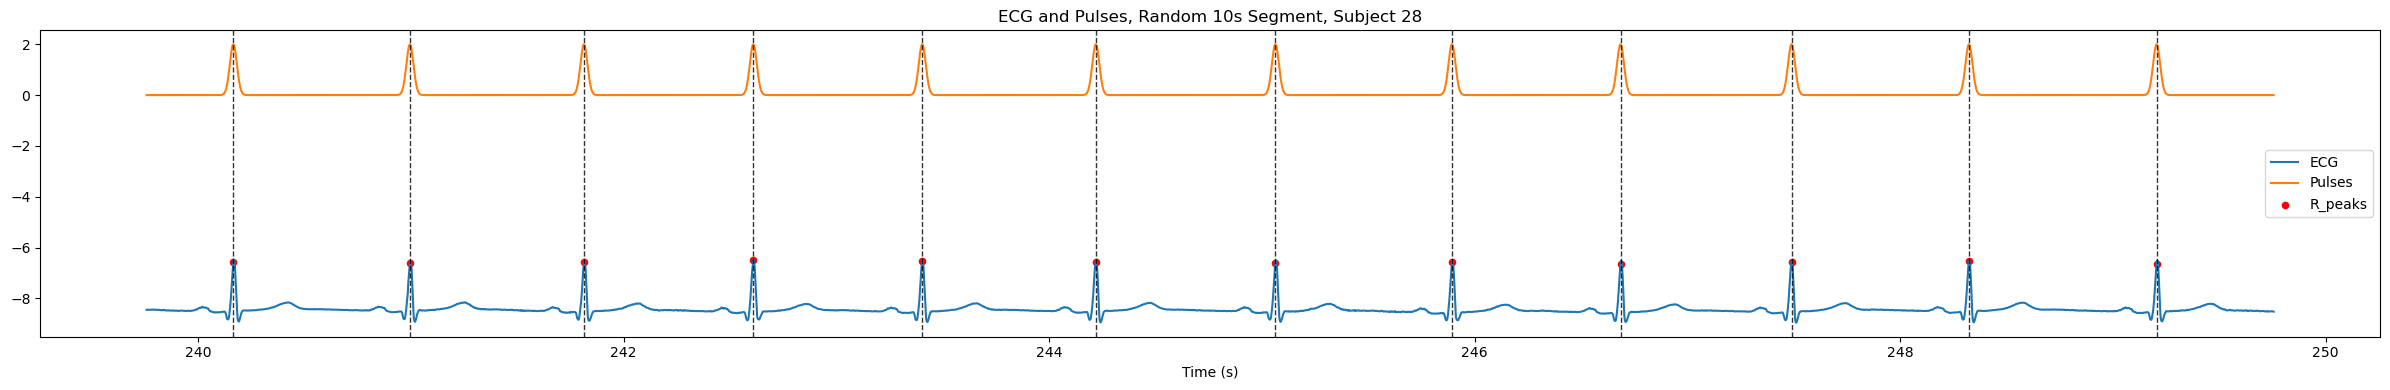


Loading training data for subject 30...
ECG -> Sampling frequency: 500.0 Hz, Signal duration: 466.57 seconds, Channels: 1, no. of points: 233285, no. of R peaks: 770
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 466.568 seconds, Channels: 128, no. of points: 233284


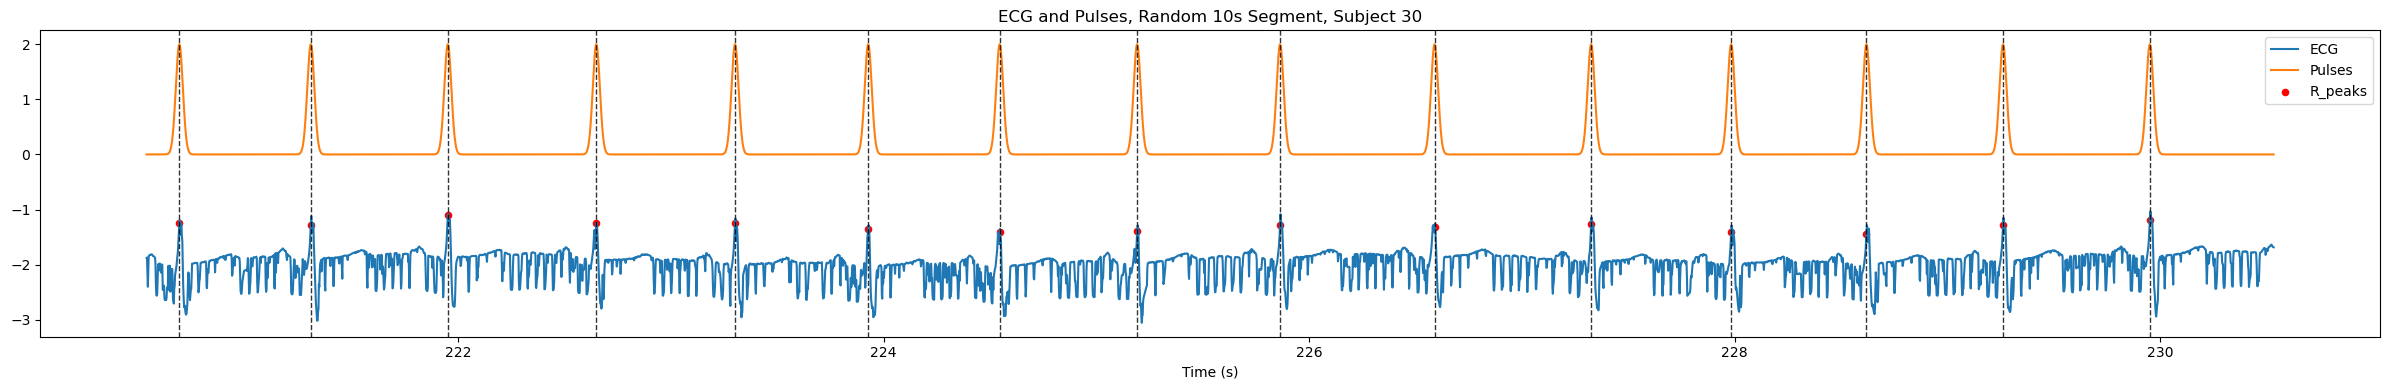


Loading training data for subject 39...
ECG -> Sampling frequency: 500.0 Hz, Signal duration: 400.918 seconds, Channels: 1, no. of points: 200459, no. of R peaks: 489
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 400.916 seconds, Channels: 128, no. of points: 200458


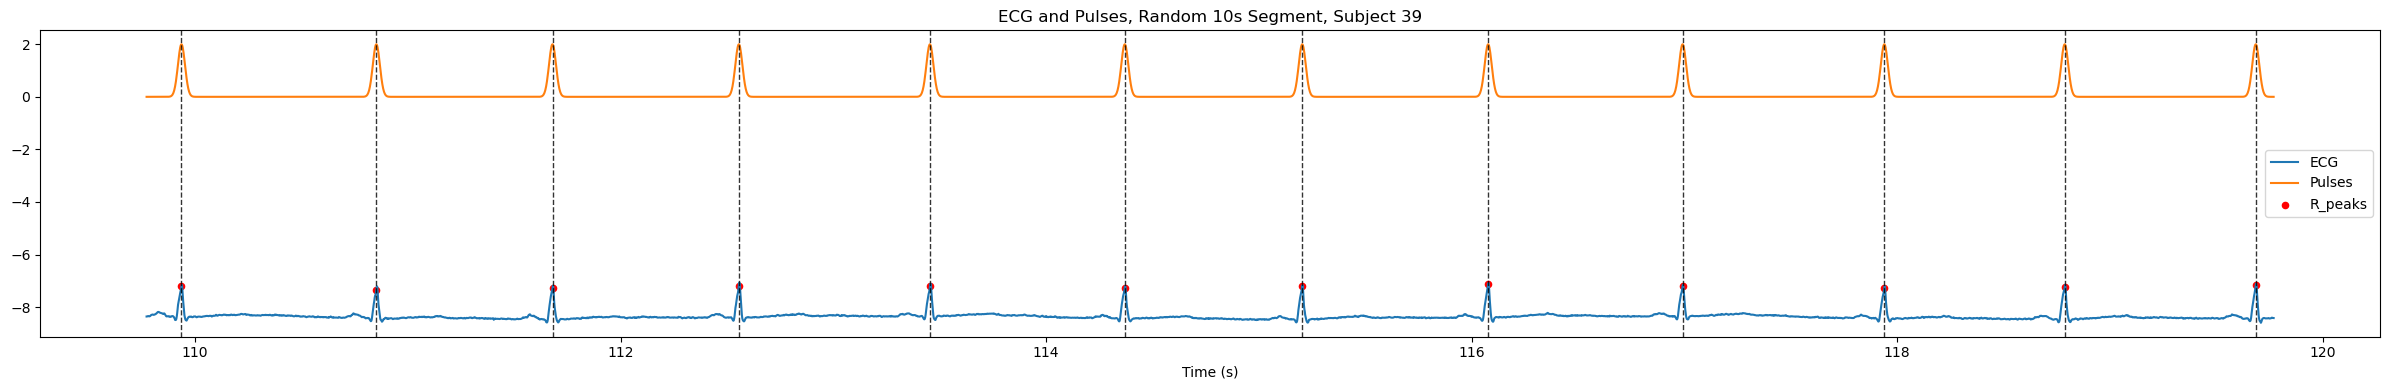


Loading training data for subject 41...
ECG -> Sampling frequency: 500.0 Hz, Signal duration: 428.97 seconds, Channels: 1, no. of points: 214485, no. of R peaks: 452
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 428.968 seconds, Channels: 128, no. of points: 214484


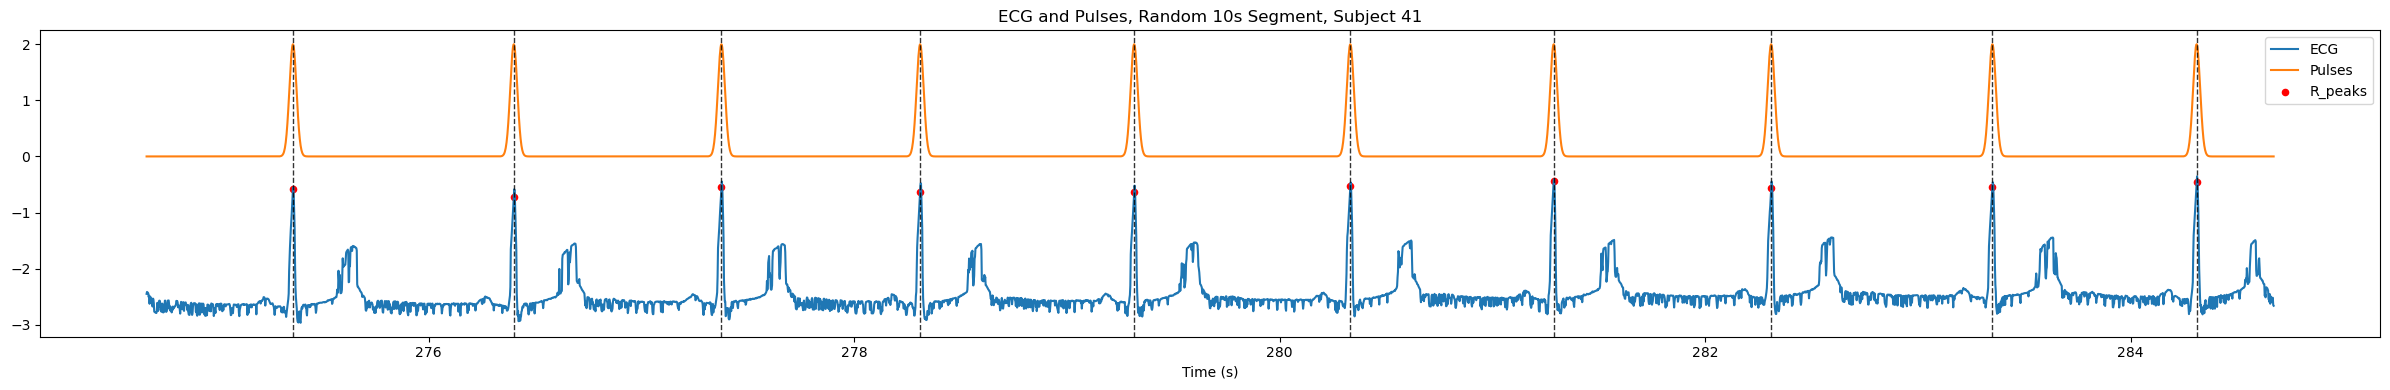

Saved data_parsed to cache\data_parsed_noSubsample.pkl


In [9]:
data_parsed = {}  # main dictionary: keys are subjects

if load_from_file and os.path.exists(parsed_path):
    with open(parsed_path, "rb") as f:
        data_parsed = pickle.load(f)
    print(f"Loaded data_parsed from {parsed_path}")
    # visualize each subject from cached data
    for ss in subj_all:
        d = data_parsed[ss]
        visualize_ecg_and_peaks(ss, d['ECG'], d['ECG_pulse'], d['EEG'], d['R_peaks'], d['time'], d['freq'], duration_sec=duration_sec)
else:
    for ss in subj_all:
        print(f"\nLoading training data for subject {ss}...")

        # Load preprocessed EEG
        data = loadmat(f'Signals/P0{ss:02d}_prepro.mat' if prepro else f'Signals/P0{ss:02d}_raw.mat' )
        EEG_prepro = data['EEG_prepro' if prepro else 'EEG']
        Y_prepro = EEG_prepro['data'][0, 0].astype(float)
        freq_prepro = float(EEG_prepro['srate'][0, 0])

        # Load ECG
        ecg_data = loadmat(f'Signals/P0{ss:02d}.mat')
        t_prepro = ecg_data["t_int"].flatten()
        t_prepro = np.insert(t_prepro, 0, 0.0)  # add a first point 0.0 to correct the shape

        R_peak = ecg_data['R_peak'].flatten() - 1
        ECG = ecg_data['ECG_i'].flatten() 
        ECG = np.insert(ECG, len(ECG), ECG[len(ECG) - 1])  # add a last point to correct the shape, by repeating the last point

        # Pulse train
        ECG_pulse = train_pulse(Y_prepro, R_peak, A, width, freq_prepro, impulso)

        # Store in nested dictionary
        data_parsed[ss] = {
            'ECG': ECG,
            'ECG_pulse': ECG_pulse,
            'R_peaks': R_peak,
            'EEG': Y_prepro,
            'time': t_prepro,
            'freq': freq_prepro
        }

        visualize_ecg_and_peaks(ss, ECG, ECG_pulse, Y_prepro, R_peak, t_prepro, freq_prepro, duration_sec=duration_sec)

    os.makedirs(cache_dir, exist_ok=True)
    with open(parsed_path, "wb") as f:
        pickle.dump(data_parsed, f)
    print(f"Saved data_parsed to {parsed_path}")

ECG -> Sampling frequency: 500 Hz, Signal duration: 466.57 seconds, Channels: 1, no. of points: 233285, no. of R peaks: 546
EEG -> Sampling frequency: 500 Hz, Signal duration: 466.568 seconds, Channels: 128, no. of points: 233284


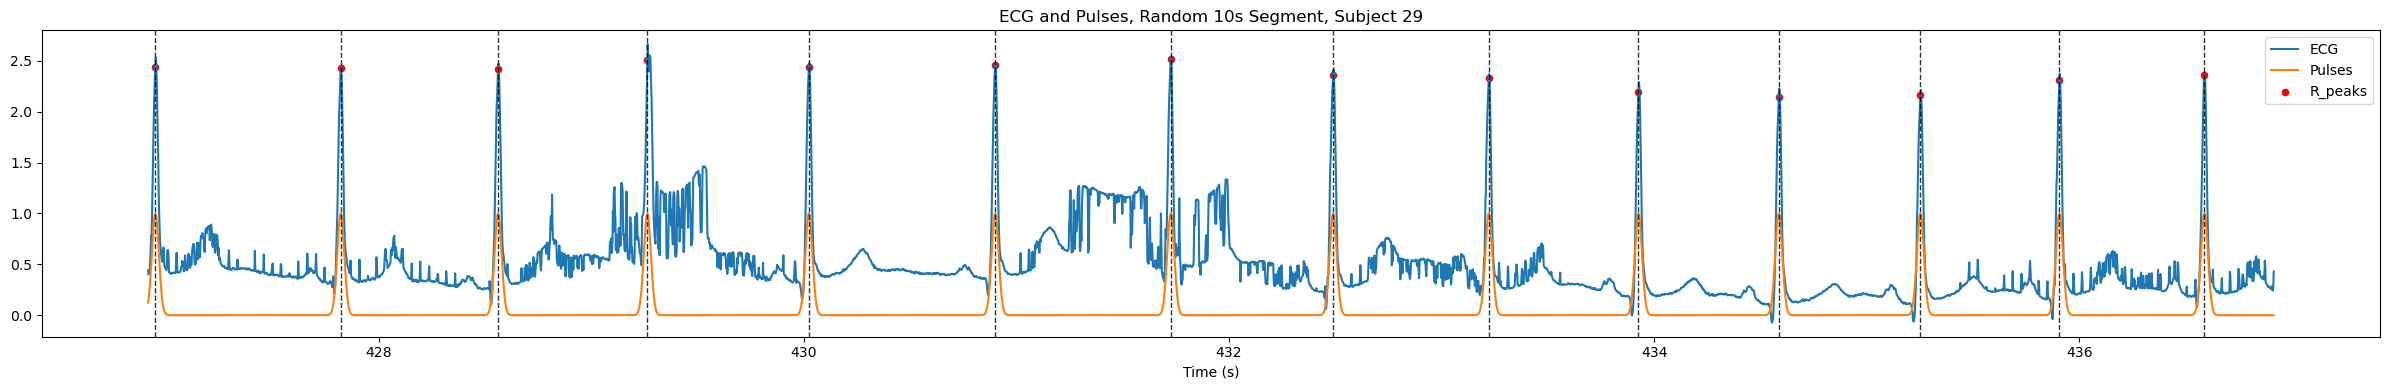

ECG -> Sampling frequency: 500 Hz, Signal duration: 462.22 seconds, Channels: 1, no. of points: 231110, no. of R peaks: 711
EEG -> Sampling frequency: 500 Hz, Signal duration: 462.218 seconds, Channels: 128, no. of points: 231109


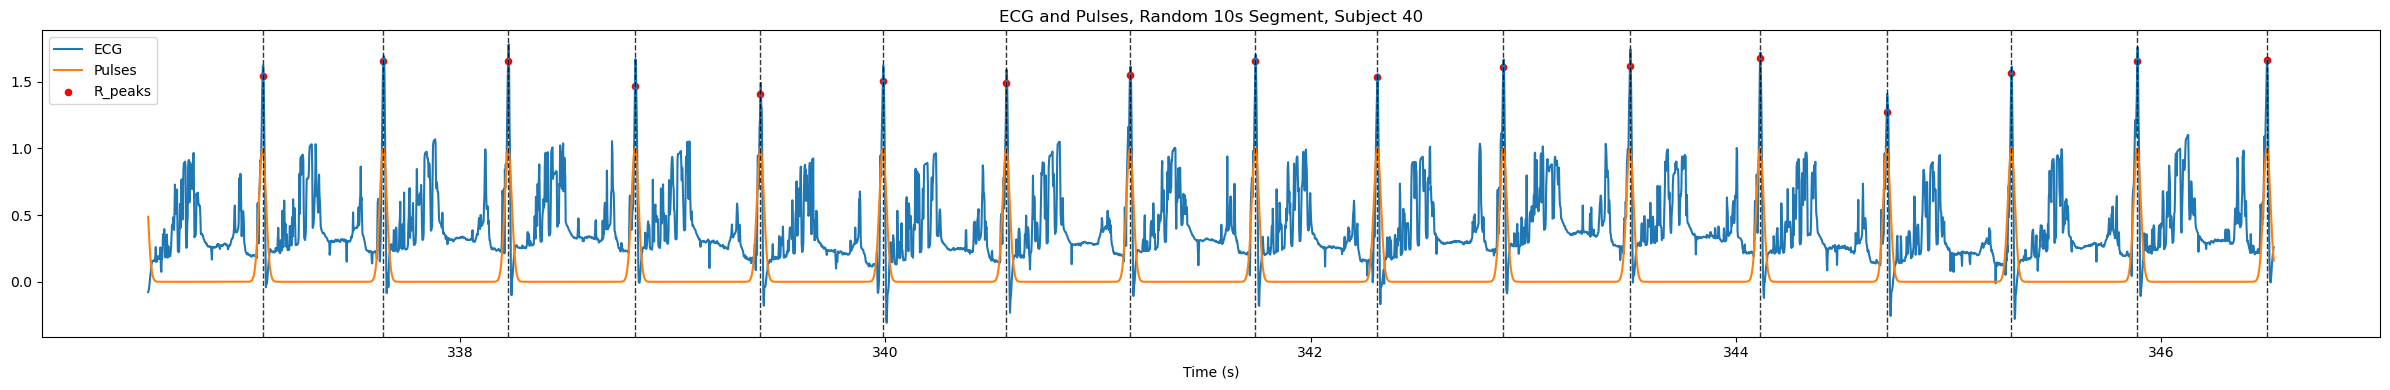

ECG -> Sampling frequency: 500 Hz, Signal duration: 509.77 seconds, Channels: 1, no. of points: 254885, no. of R peaks: 537
EEG -> Sampling frequency: 500 Hz, Signal duration: 509.768 seconds, Channels: 128, no. of points: 254884


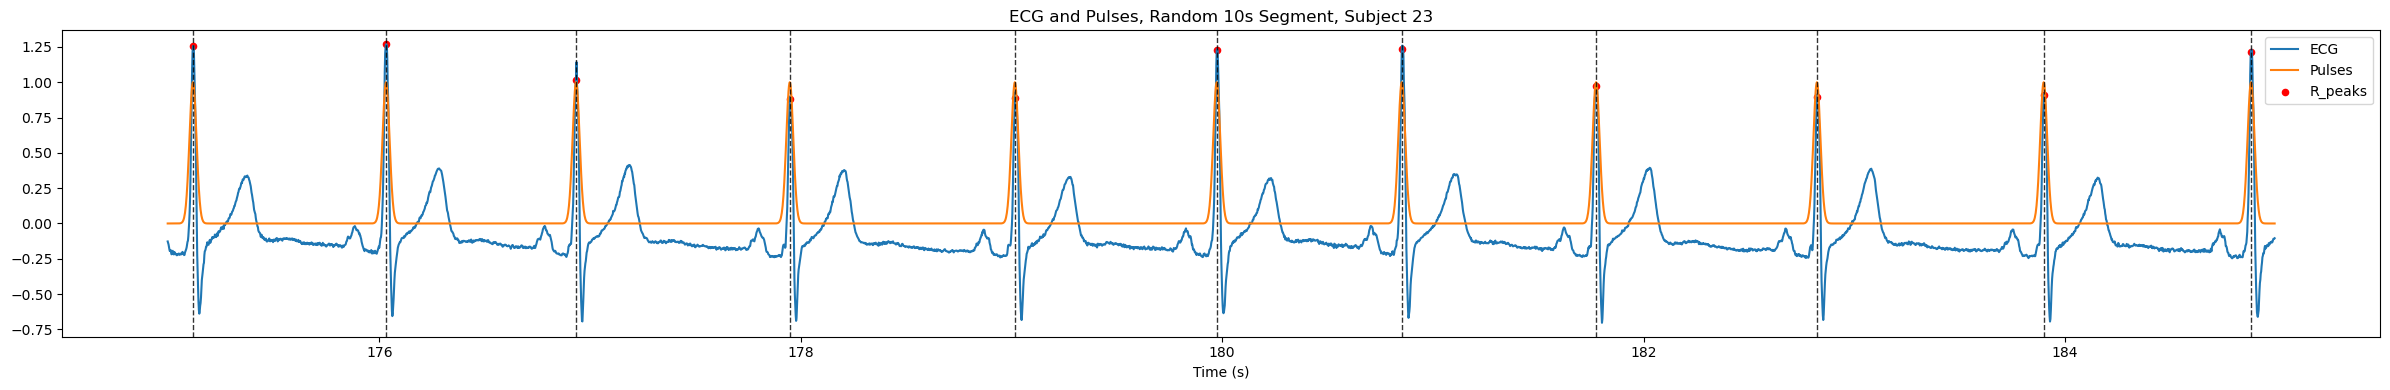

ECG -> Sampling frequency: 500 Hz, Signal duration: 446.216 seconds, Channels: 1, no. of points: 223108, no. of R peaks: 549
EEG -> Sampling frequency: 500 Hz, Signal duration: 446.214 seconds, Channels: 128, no. of points: 223107


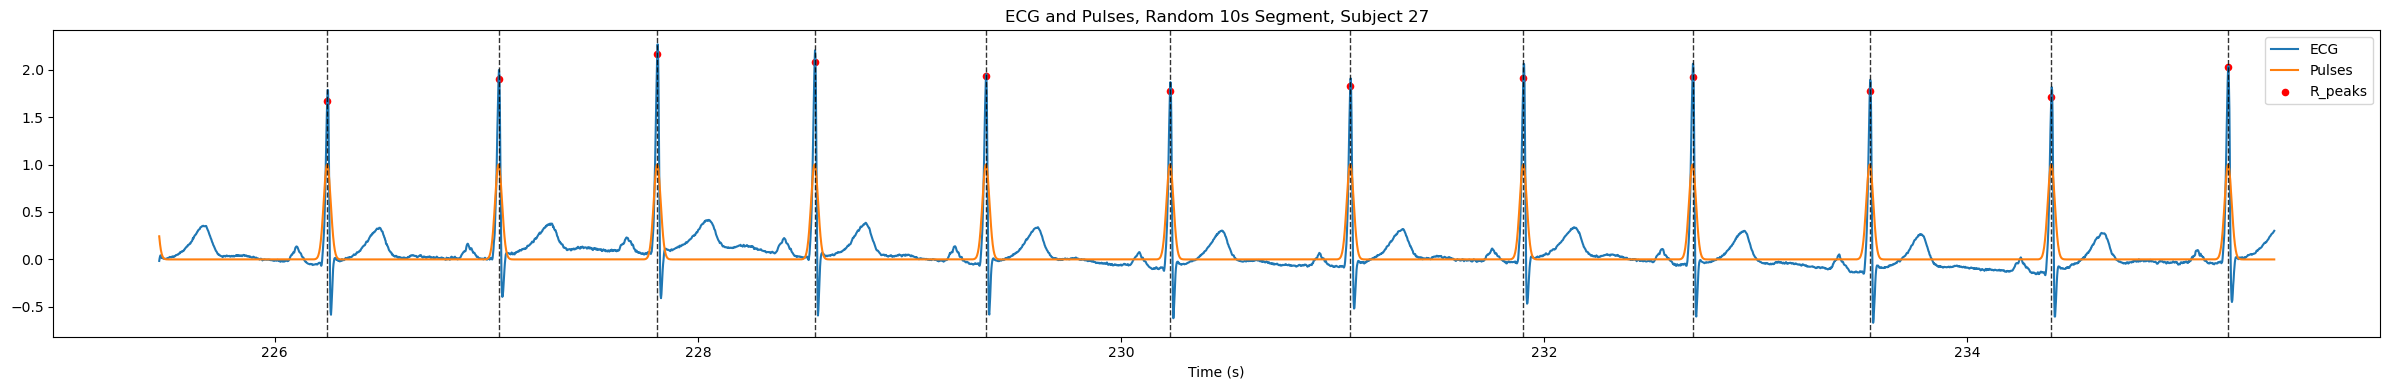

ECG -> Sampling frequency: 500 Hz, Signal duration: 422.668 seconds, Channels: 1, no. of points: 211334, no. of R peaks: 505
EEG -> Sampling frequency: 500 Hz, Signal duration: 422.666 seconds, Channels: 128, no. of points: 211333


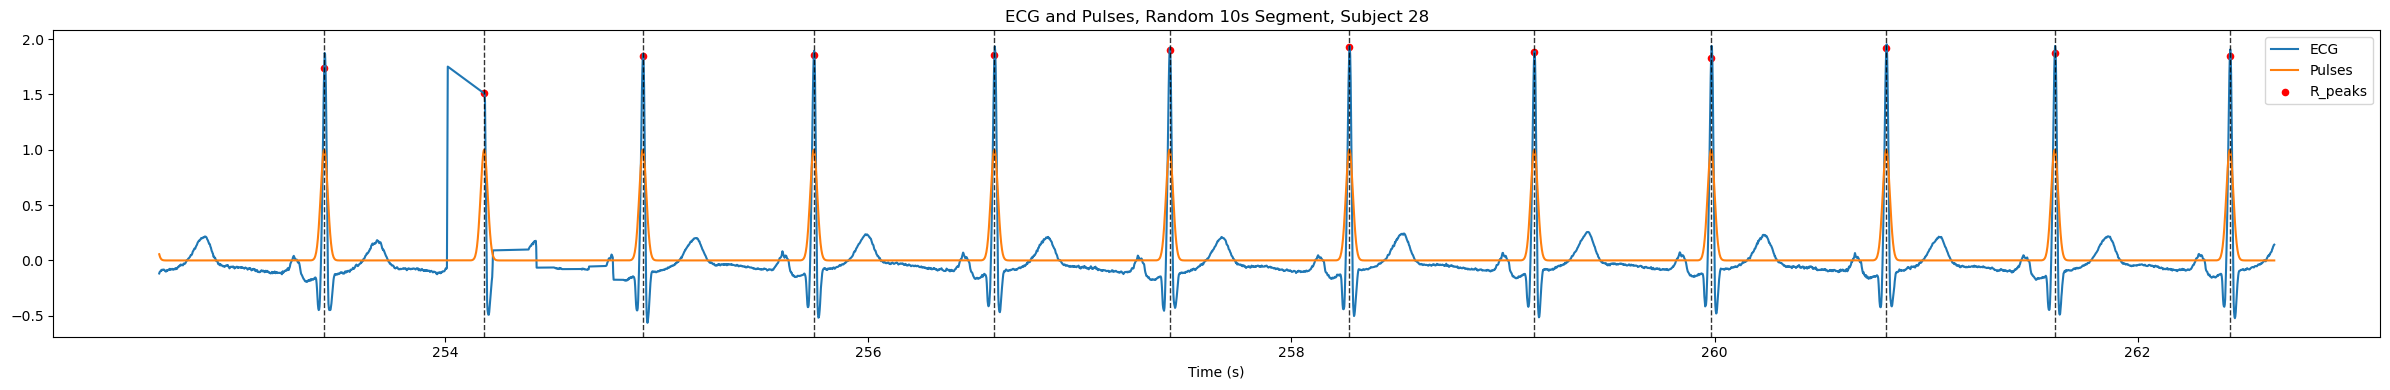

ECG -> Sampling frequency: 500 Hz, Signal duration: 466.57 seconds, Channels: 1, no. of points: 233285, no. of R peaks: 770
EEG -> Sampling frequency: 500 Hz, Signal duration: 466.568 seconds, Channels: 128, no. of points: 233284


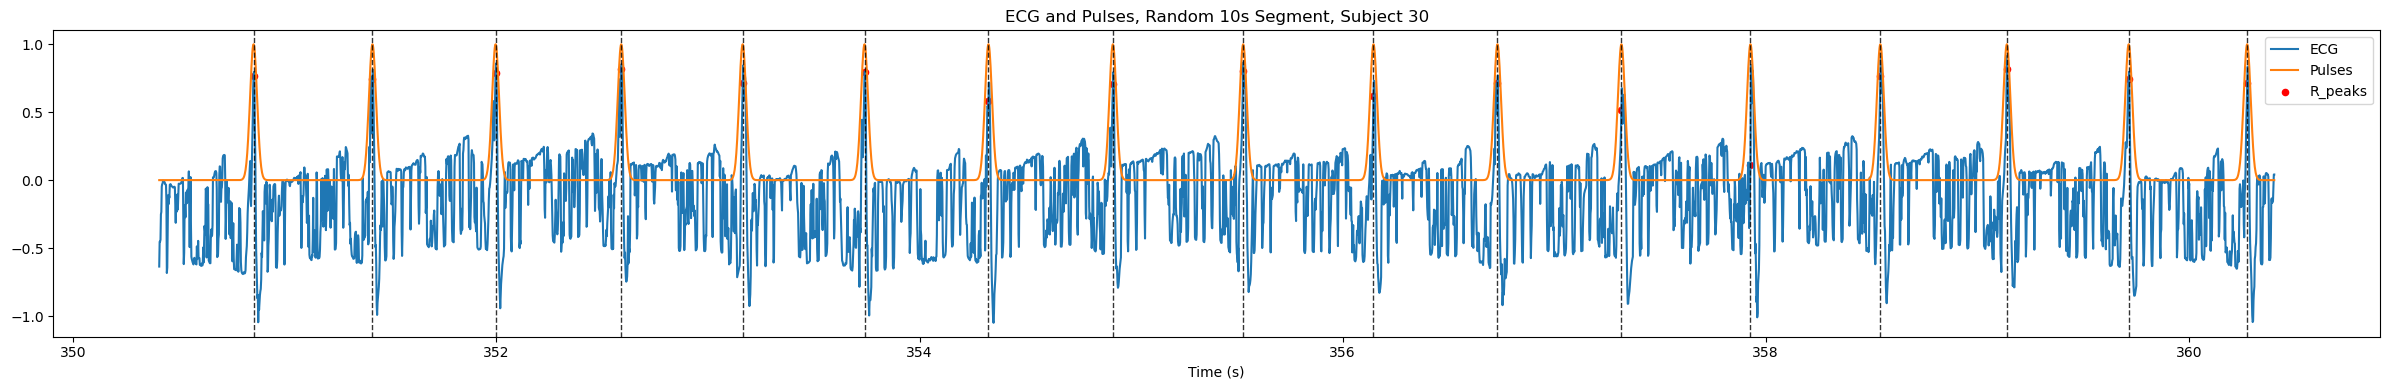

ECG -> Sampling frequency: 500 Hz, Signal duration: 400.918 seconds, Channels: 1, no. of points: 200459, no. of R peaks: 489
EEG -> Sampling frequency: 500 Hz, Signal duration: 400.916 seconds, Channels: 128, no. of points: 200458


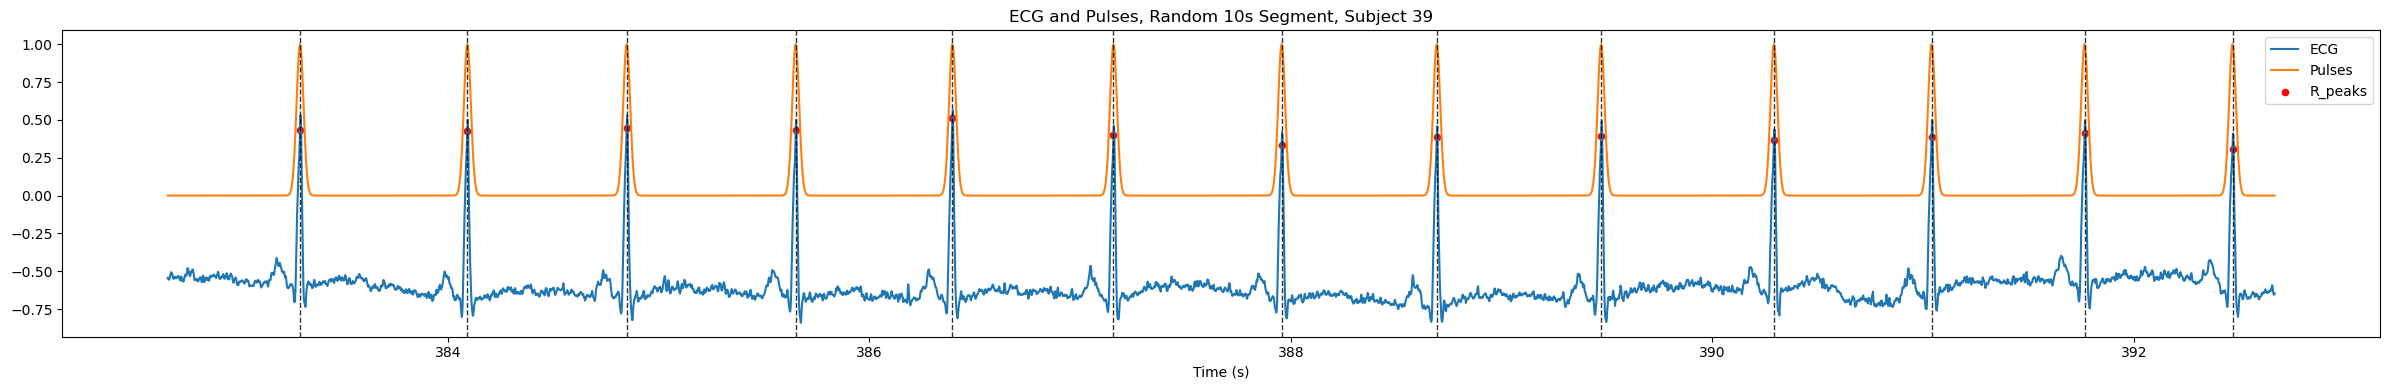

ECG -> Sampling frequency: 500 Hz, Signal duration: 428.97 seconds, Channels: 1, no. of points: 214485, no. of R peaks: 452
EEG -> Sampling frequency: 500 Hz, Signal duration: 428.968 seconds, Channels: 128, no. of points: 214484


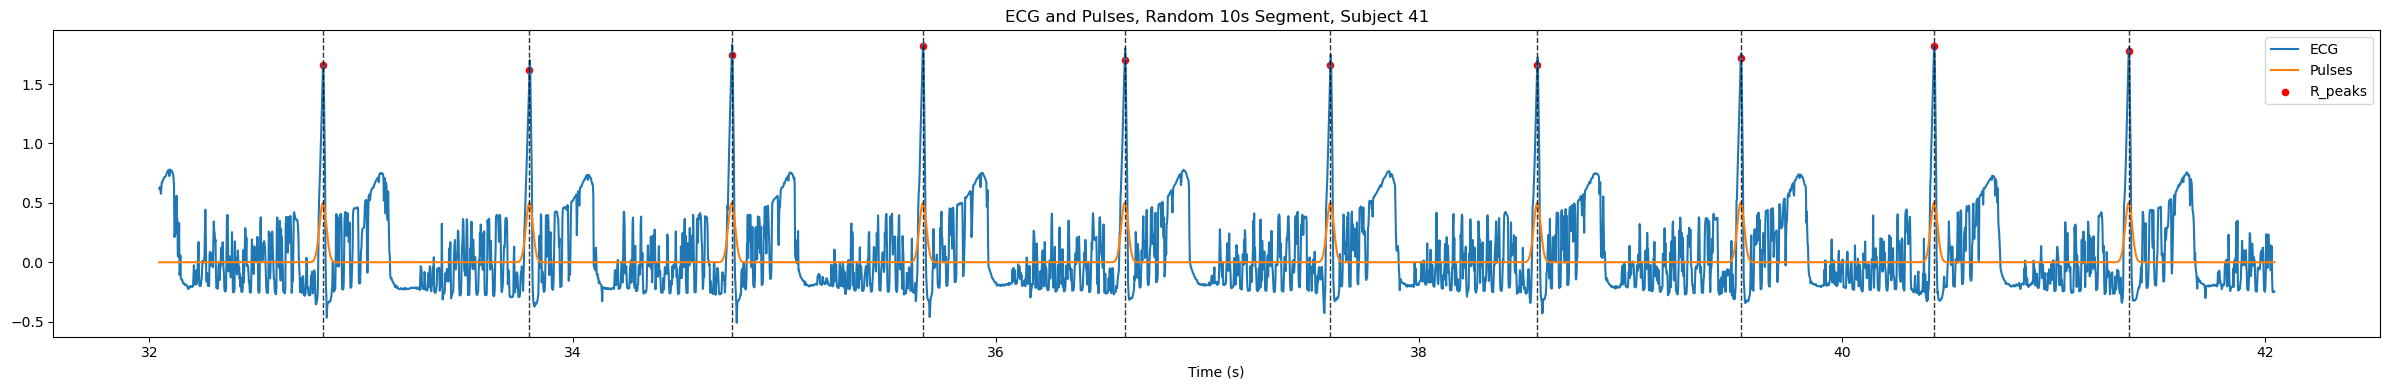

Saved data_preprocessed to cache\data_preprocessed_noSubsample.pkl


In [10]:
data_preprocessed = {}

if load_from_file and os.path.exists(preproc_path):
    with open(preproc_path, "rb") as f:
        data_preprocessed = pickle.load(f)
    print(f"Loaded data_preprocessed from {preproc_path}")
    for ss in subj_all:
        d = data_preprocessed[ss]
        visualize_ecg_and_peaks(ss, d['ECG'], d['ECG_pulse'], d['EEG'], d['R_peaks'], d['time'], d['freq'], duration_sec=duration_sec)
else:
    for ss in subj_all:

        ECG = data_parsed[ss]['ECG'].copy() - np.mean(data_parsed[ss]['ECG'])
        ECG = ECG[::tau]

        ECG_pulse = minmax_scale(data_parsed[ss]['ECG_pulse'].copy().reshape(1, -1), feature_range=(0, 1), axis=1).flatten()
        ECG_pulse = ECG_pulse[::tau]

        EEG = minmax_scale(data_parsed[ss]['EEG'].copy(), feature_range=(0, 1), axis=1)
        EEG = EEG - np.mean(EEG, axis=1, keepdims=True)
        EEG = EEG[:, ::tau]

        R_peaks = data_parsed[ss]['R_peaks'].copy() // tau

        time = data_parsed[ss]['time'].copy()[::tau]
        freq = int(data_parsed[ss]['freq'] / tau)

        data_preprocessed[ss] = {
            'ECG': ECG,
            'ECG_pulse': ECG_pulse,
            'R_peaks': R_peaks,
            'EEG': EEG,
            'time': time,
            'freq': freq
        }

        visualize_ecg_and_peaks(ss, ECG, ECG_pulse, EEG, R_peaks, time, freq, duration_sec=duration_sec)

    os.makedirs(cache_dir, exist_ok=True)
    with open(preproc_path, "wb") as f:
        pickle.dump(data_preprocessed, f)
    print(f"Saved data_preprocessed to {preproc_path}")